In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fast_ml.feature_selection import get_constant_features
from sklearn.model_selection import train_test_split

# Task 1

Task one will focus on combining our individual datasets, getting the combined dataset cleaned, and then preparing the data for the ensuing machine learning tasks. To this end, we will be implementing a train-test split, and then looking for potential correlations in the training set between various continuous/categorical features, and the target death_yn feature. 

In [227]:
#Combining the two datasets and saving as a new csv
df1 = pd.read_csv('covid19-cdc-22207000.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)
df2 = pd.read_csv('covid19-cdc-12468998.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

combined_df = pd.concat([df1, df2])

combined_df.to_csv('covid19-cdc-combined-22207000-12468998.csv', index=False)

# Data Cleaning

To clean our data reuse some of the code we had employed earlier on in the course. We first concatenate these files in the below cell block, and run this file through our scrubber.

The product of this scrubber is <b>finalised-covid19-cdc-combined-22207000-12468998.csv</b>

In [228]:
#Reading the post-scrubbed CSV and checking length
df = pd.read_csv('finalised-covid19-cdc-combined-22207000-12468998.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

print(len(df))

35465


In [229]:
df.duplicated().sum()

5745

# Train/Test Split

With the data cleaning taken care of, we can now conduct a train text split on the data to prepare it for future machine learning tasks. Once the data is split, we can plot the train frame and investigate the relationships between the features.

In [230]:
#data for task 1
df = pd.read_csv('SAMPLE_DF_CHANGE_WHEN_MISSING_FEATURES_DECIDED.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)

#train test split on data
train, test = train_test_split(df, test_size = 0.3)

In [231]:
train.shape

(24825, 15)

In [232]:
test.shape

(10640, 15)

# Correlation Between Continuous Features

Correlation:  0.012140872712114453
Weak positive correlation between these two variables.


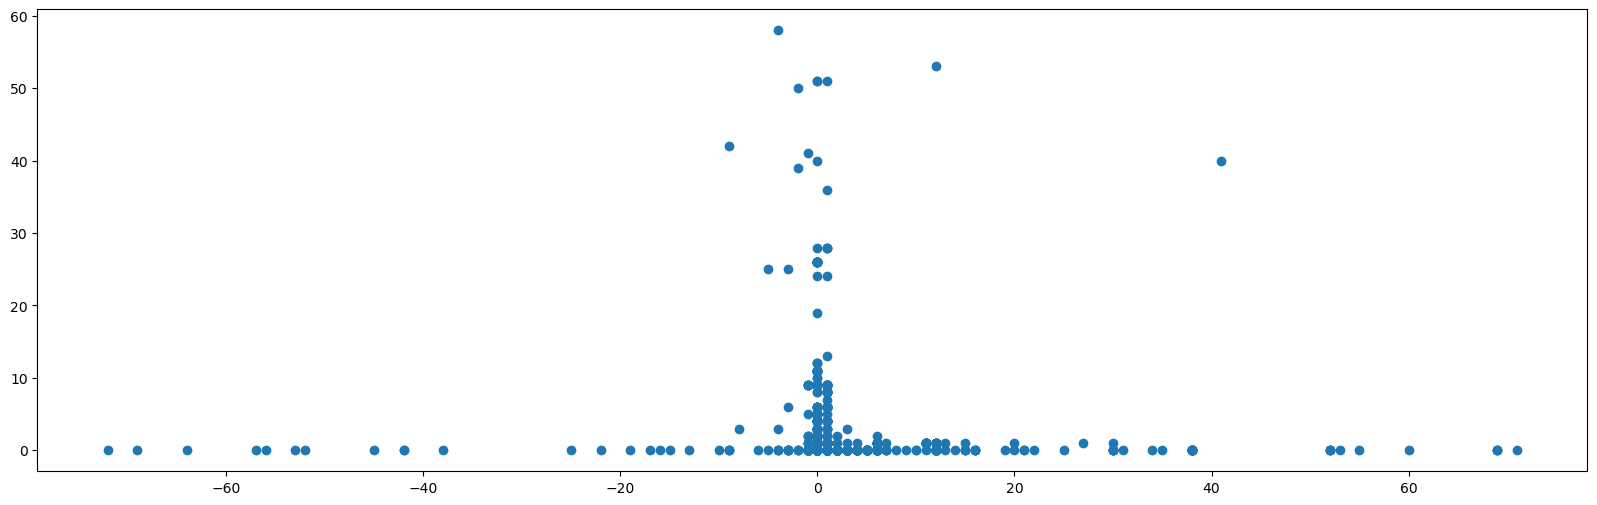

In [233]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=1, nrows=1)
plt.scatter(train['case_positive_specimen_interval'], train['case_onset_interval'])
corr = train['case_onset_interval'].corr(train['case_positive_specimen_interval'])
print('Correlation: ', corr)
print('Weak positive correlation between these two variables.')
plt.show()

# Continuous Features Plotted Against Death

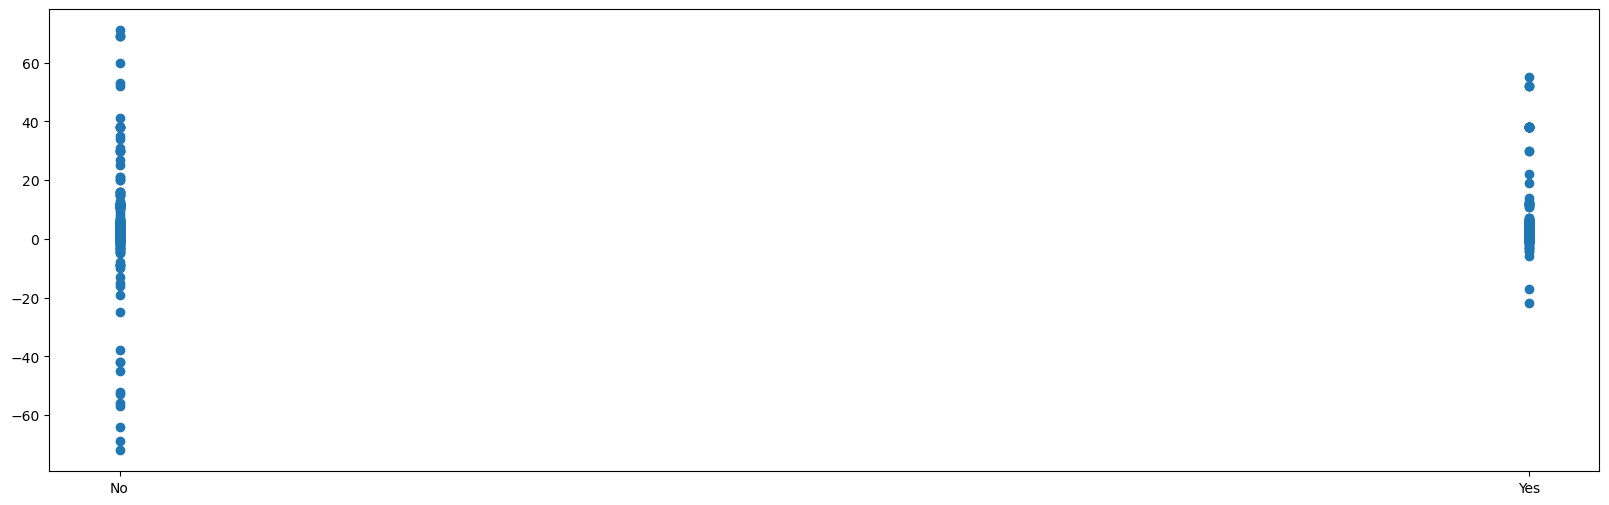

In [234]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=1, nrows=1)
plt.scatter(train['death_yn'], train['case_positive_specimen_interval'])
plt.show()

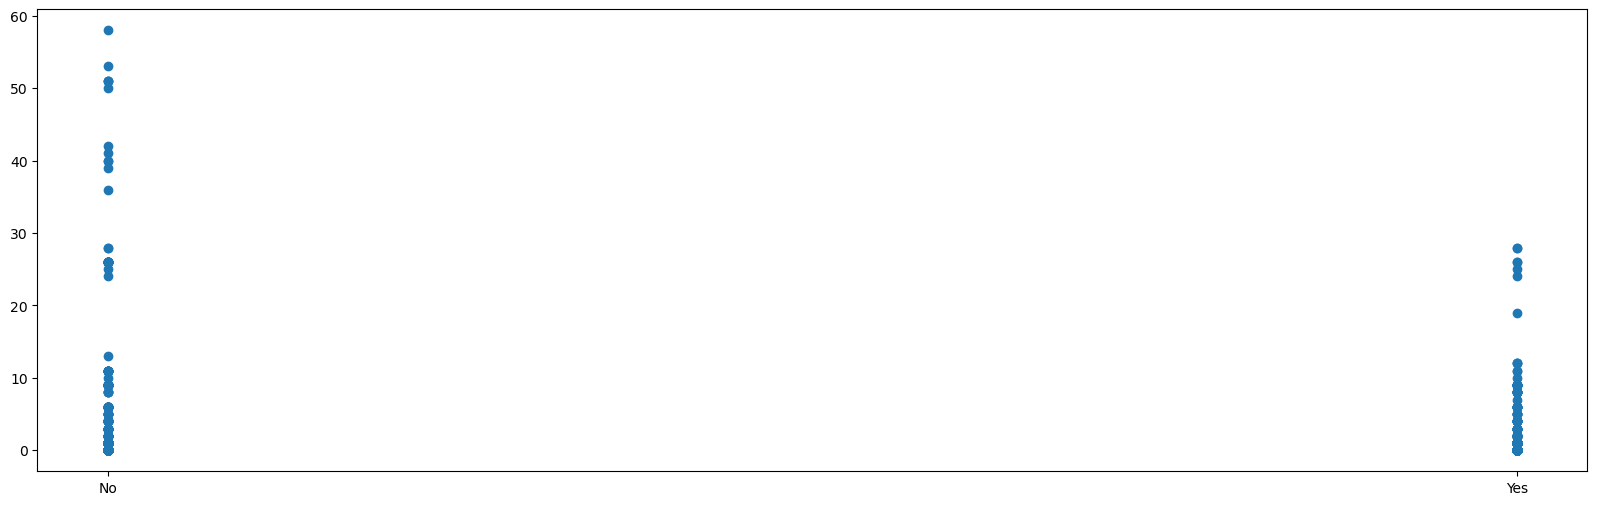

In [235]:
fig, axs = plt.subplots(figsize=(20, 6), ncols=1, nrows=1)
plt.scatter(train['death_yn'], train['case_onset_interval'])
plt.show()

# Health Related Categorical Features Plotted Against Death

Here we are looking discern patterns from our dataset by plotting deaths (yes/no) against a select number of categorical features. The features we are going to examine first are those that relate to the health profile of our patients:

1. When the patient contracted COVID.
2. What US state the patient was in when they were reported of having COVID.
3. What age group the patient belongs to.
4. Whether the patient knew if they were exposed to COVID.
5. Whether or not the patient was hospitalised or not.
6. Whether or not the patient was taken to ICU.
7. And whether or not the patient exhibited underlying conditions which could exacerbate COVID.

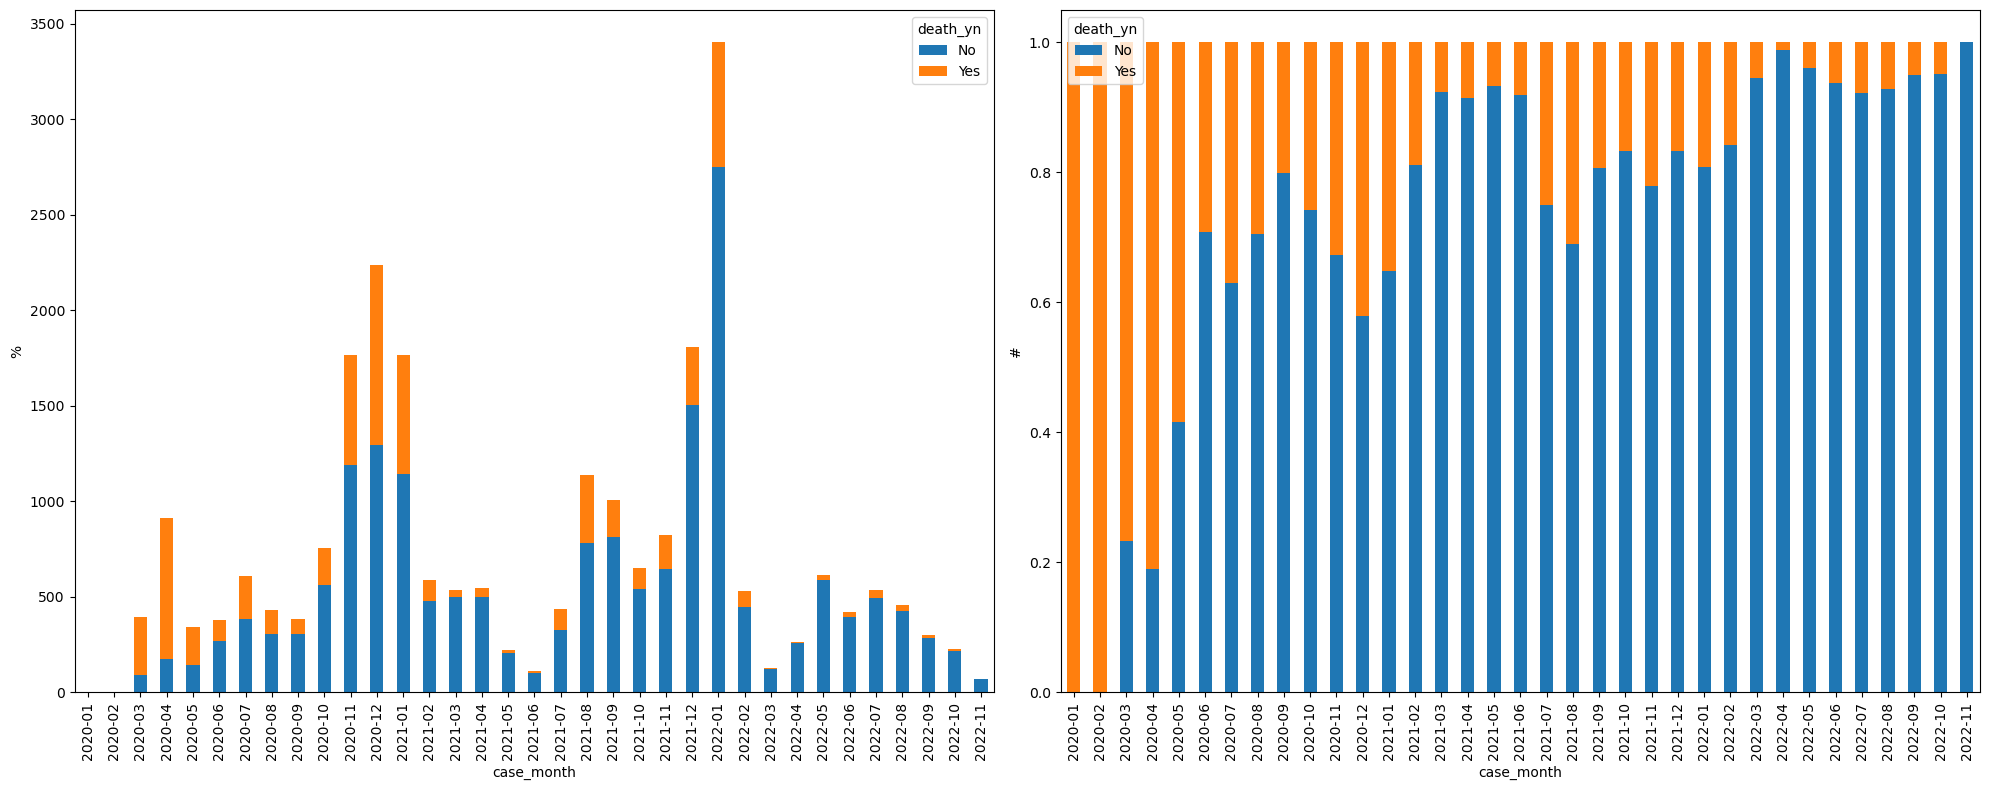

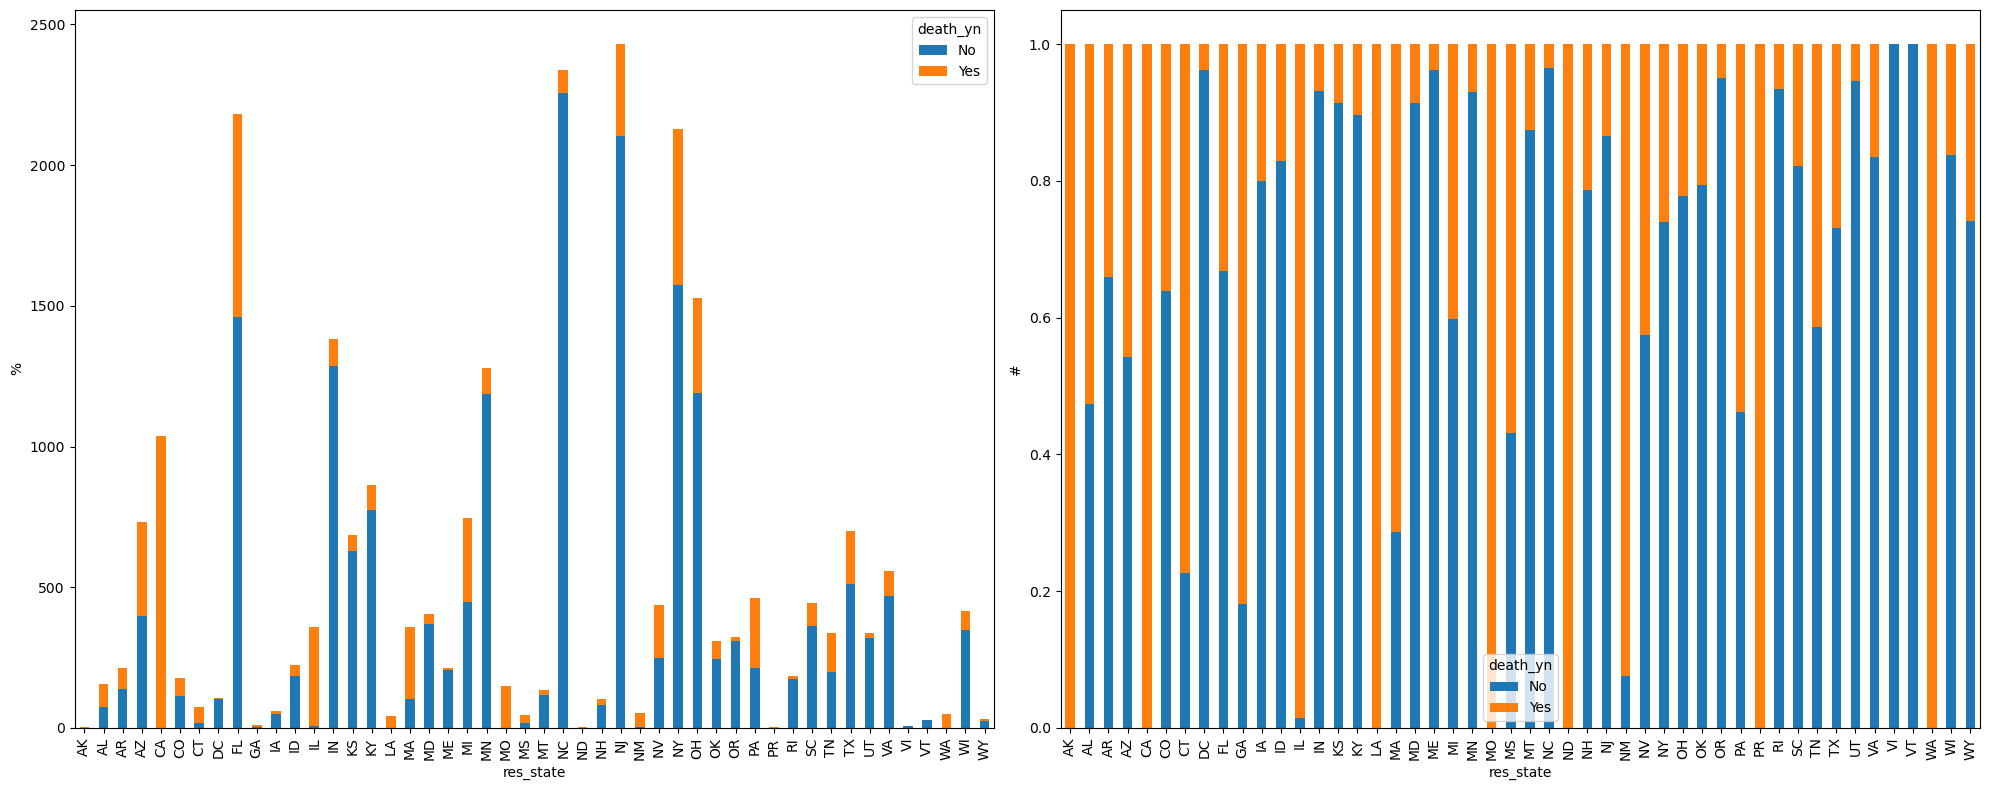

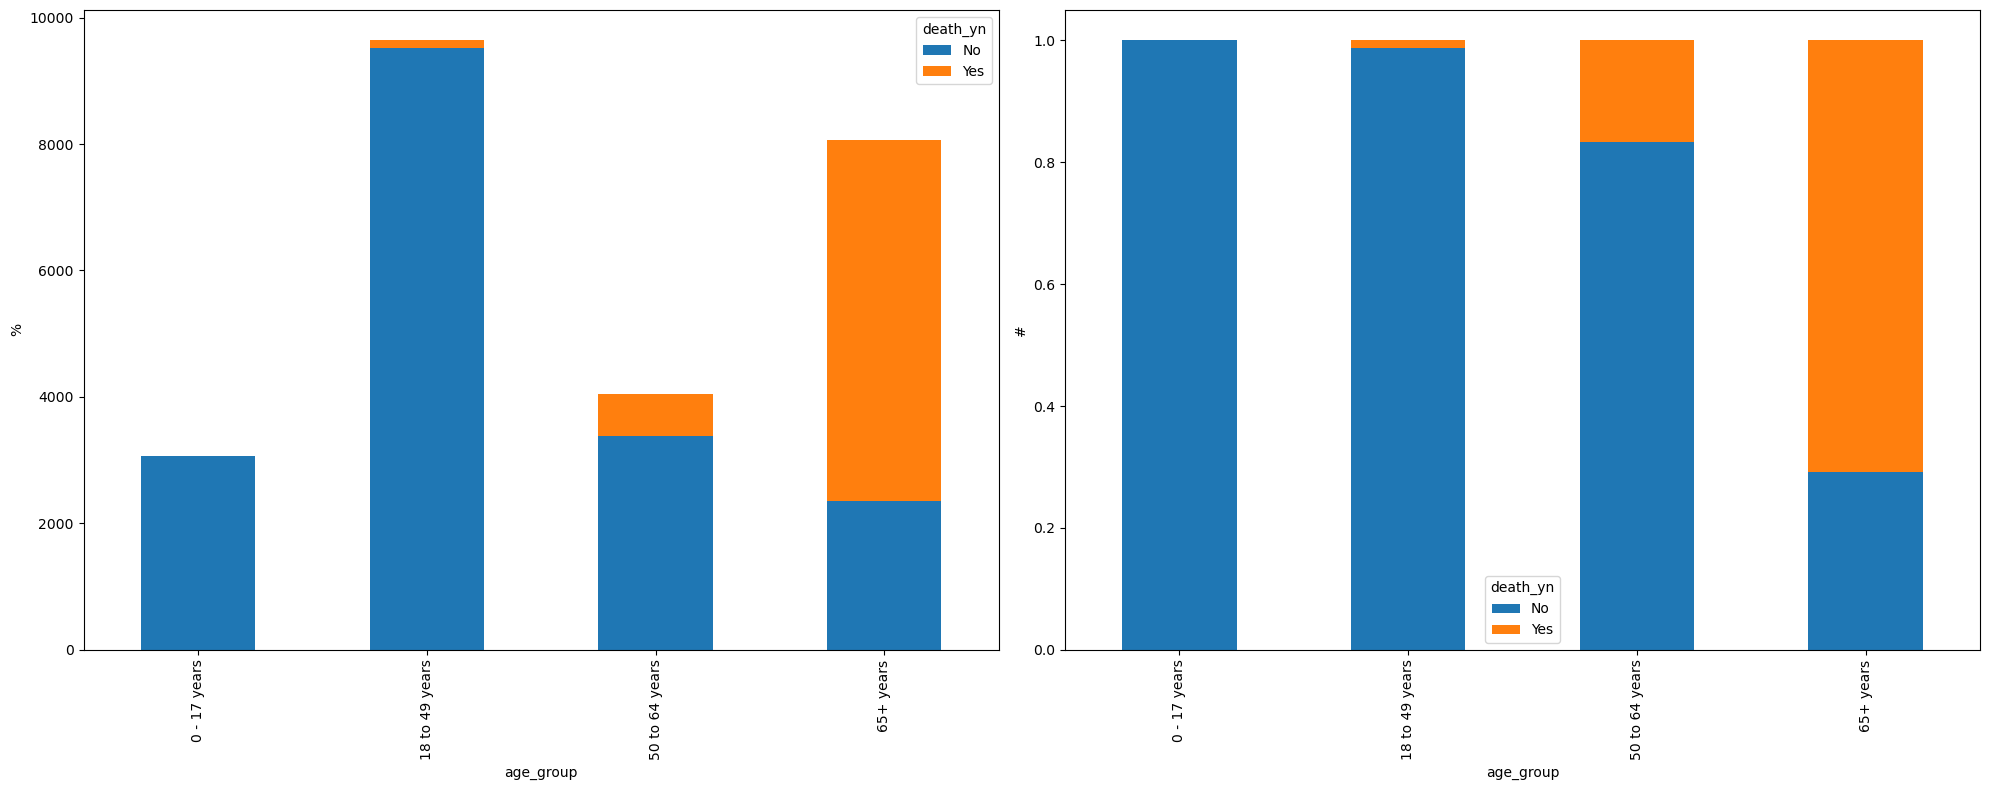

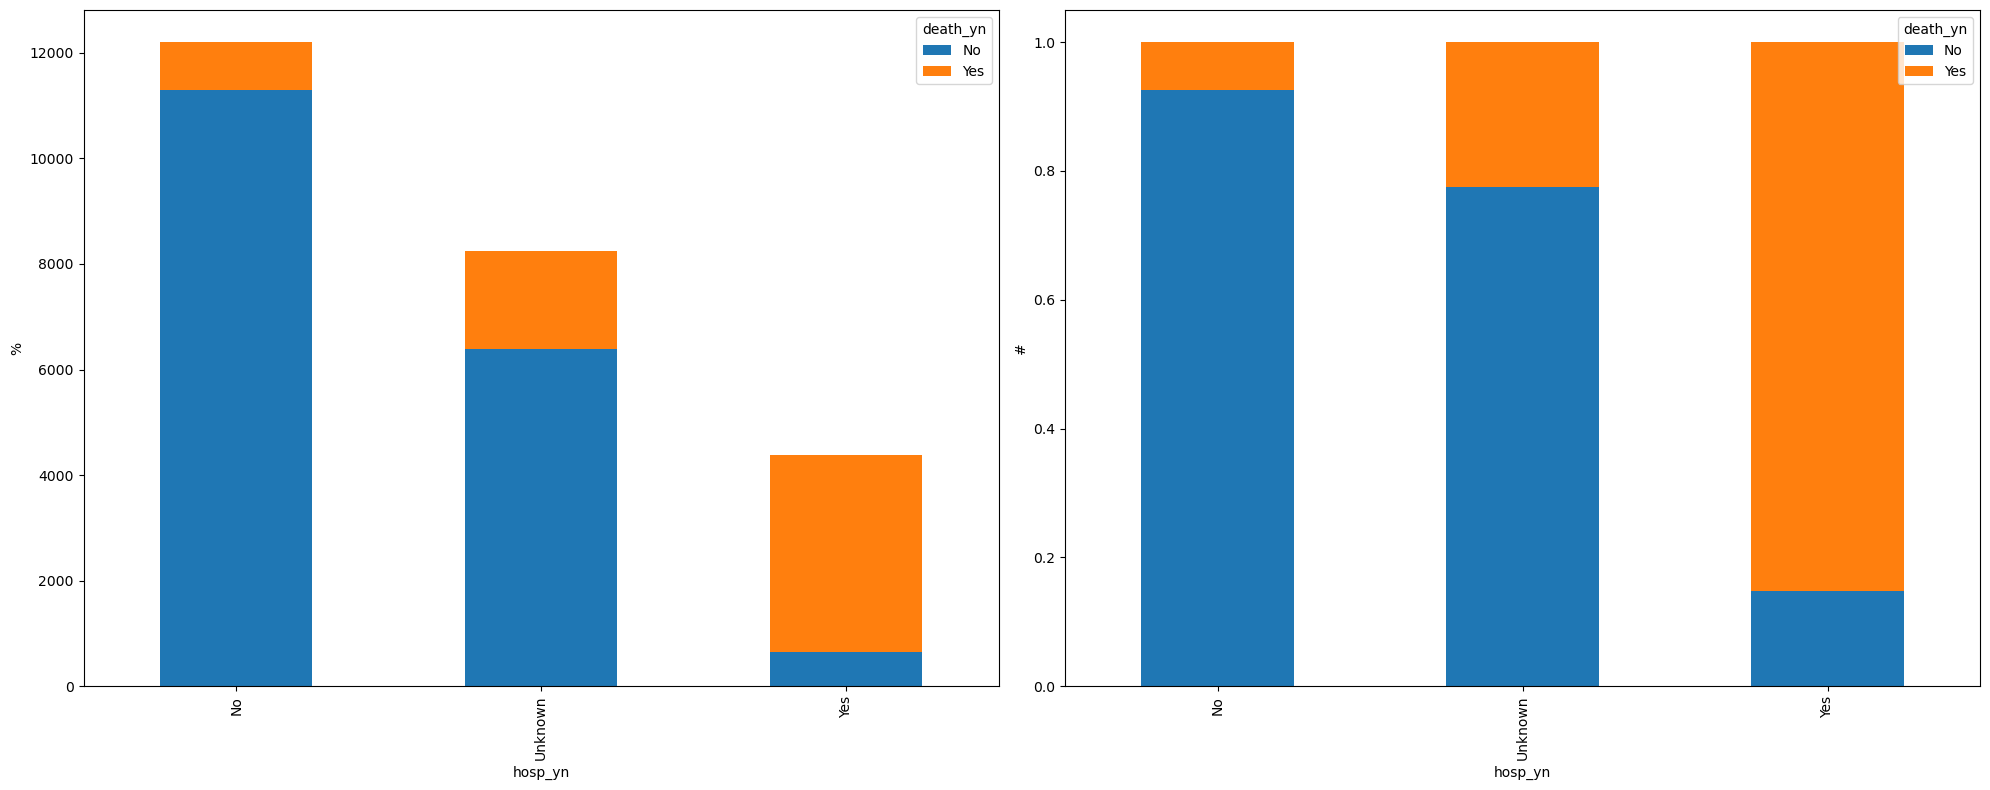

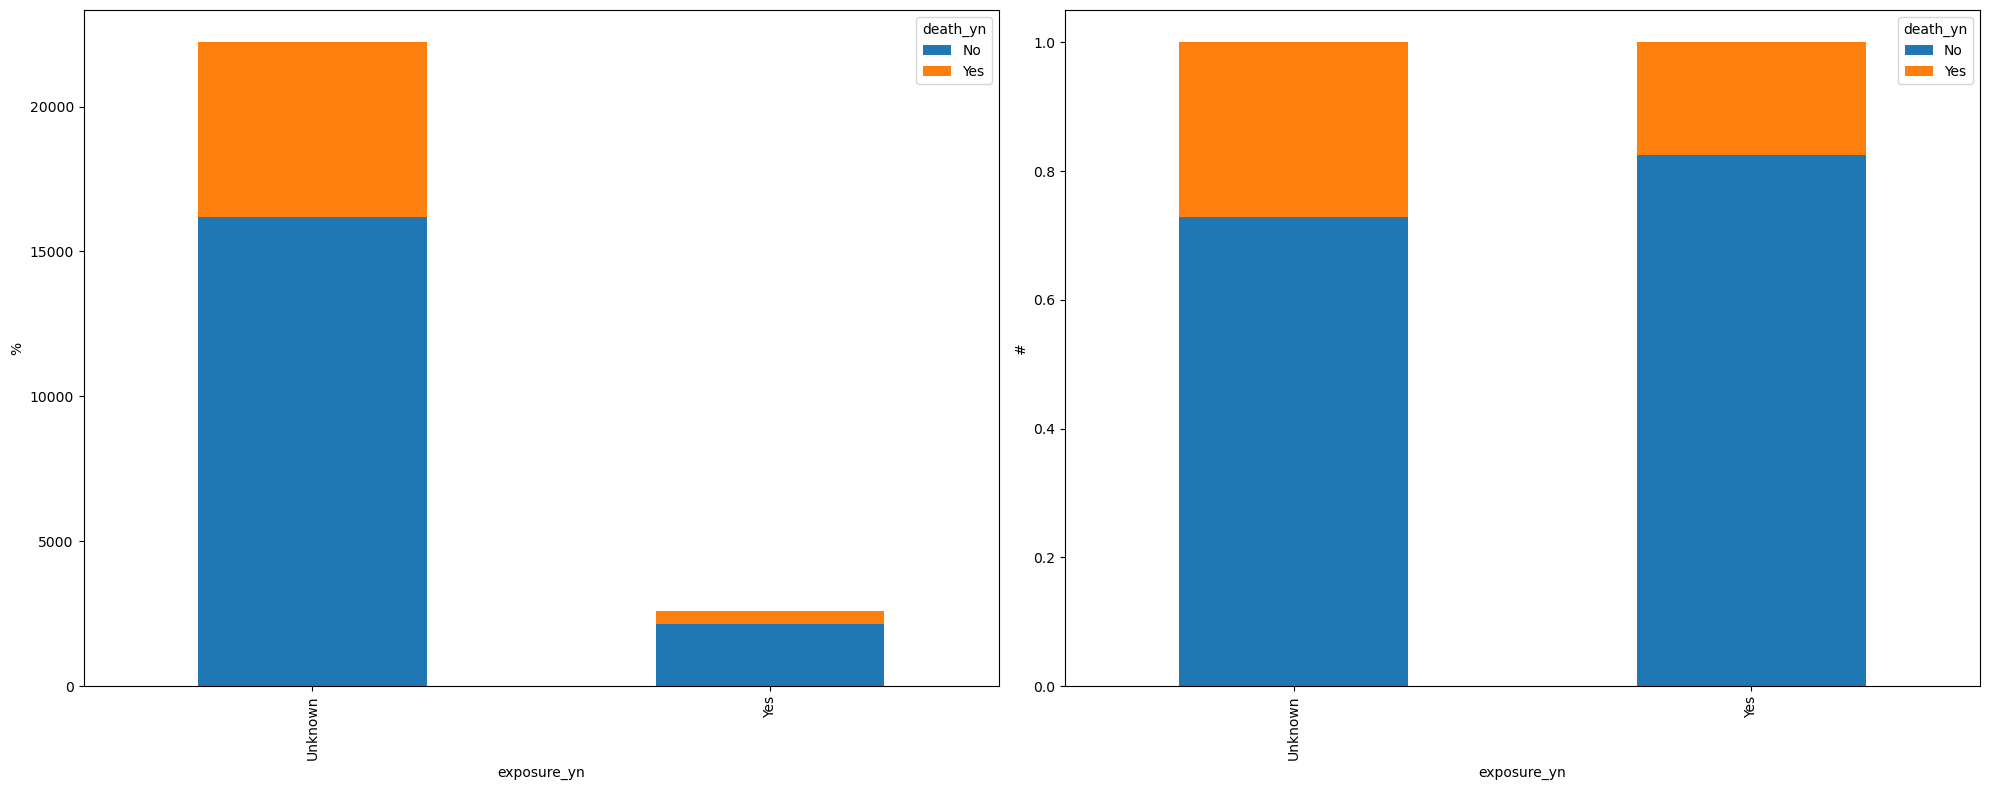

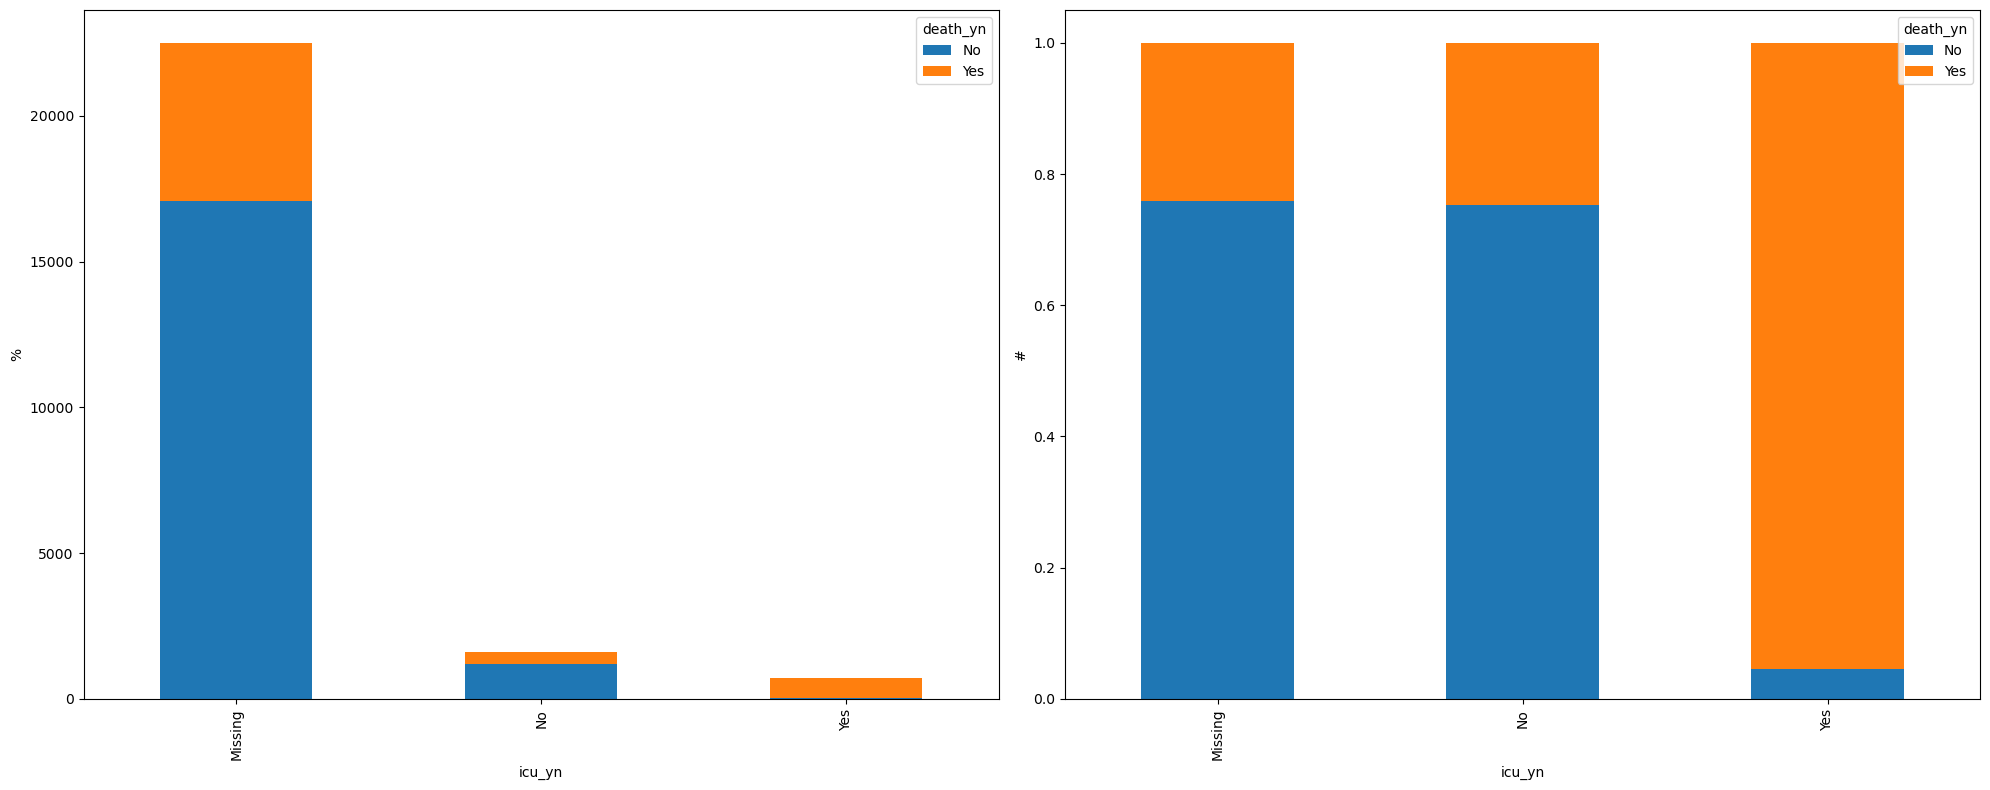

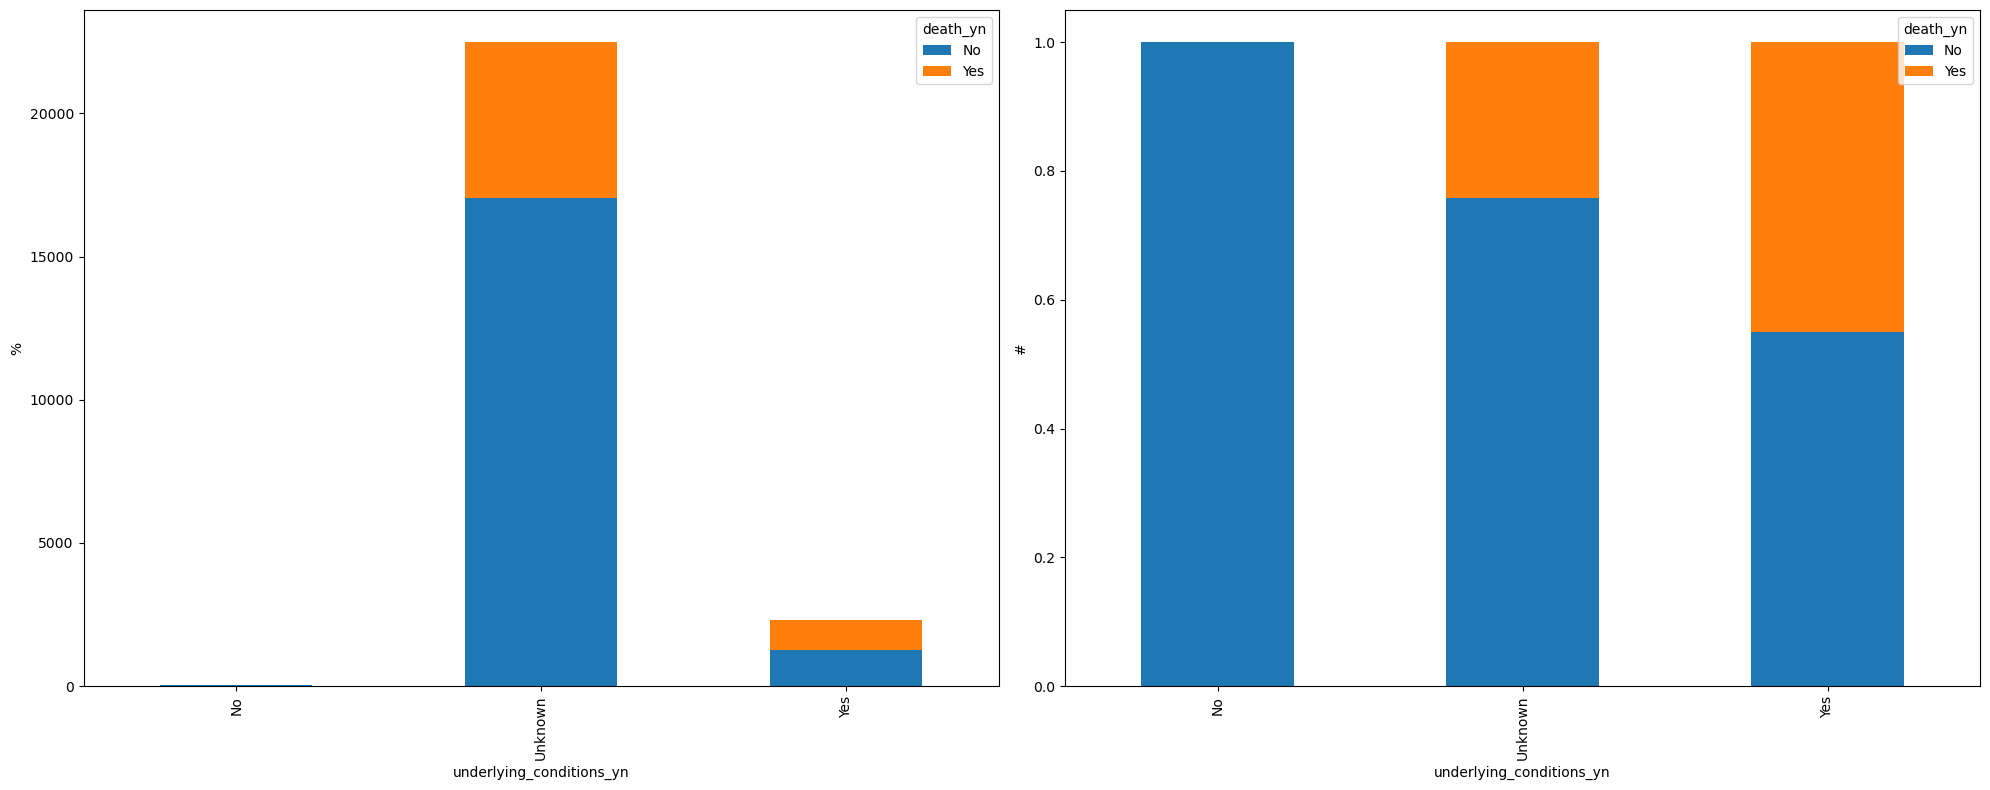

In [236]:
target_feature = train['death_yn']
select_features = [train['case_month'], train['res_state'], train['age_group'], train['hosp_yn'], train['exposure_yn'], train['icu_yn'], train['underlying_conditions_yn']]

for feature in select_features:
  
    fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
    train.groupby([feature, target_feature]).size().unstack().plot(kind='bar', stacked=True, ax=axs[0])
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=10)
    axs[0].set_ylabel('%')

    train.groupby([feature, target_feature]).size().unstack().apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=axs[1])
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=10)
    axs[1].set_ylabel('#')
    
    plt.tight_layout()
    plt.show()

# Sociological Related Categorical Features Plotted Against Death

Here we are looking discern patterns from our dataset by plotting deaths (yes/no) against a number of sociological features: race, ethnicity, sex.

1. When the patient contracted COVID.
2. What US state the patient was in when they were reported of having COVID.
3. What age group the patient belongs to.

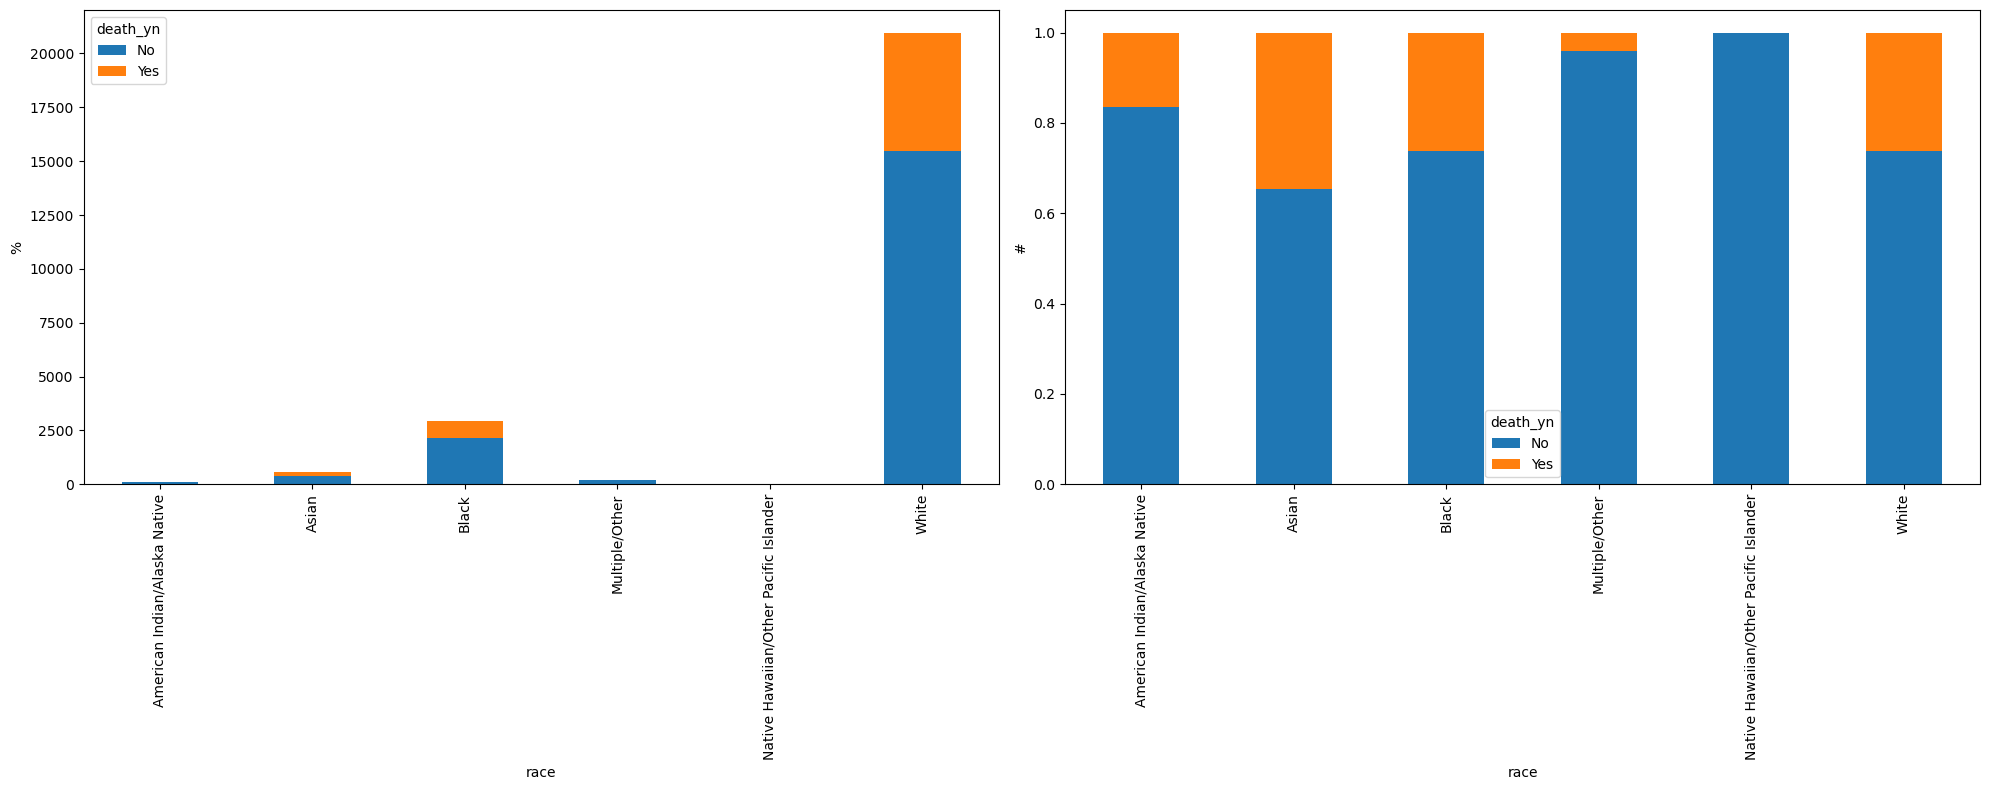

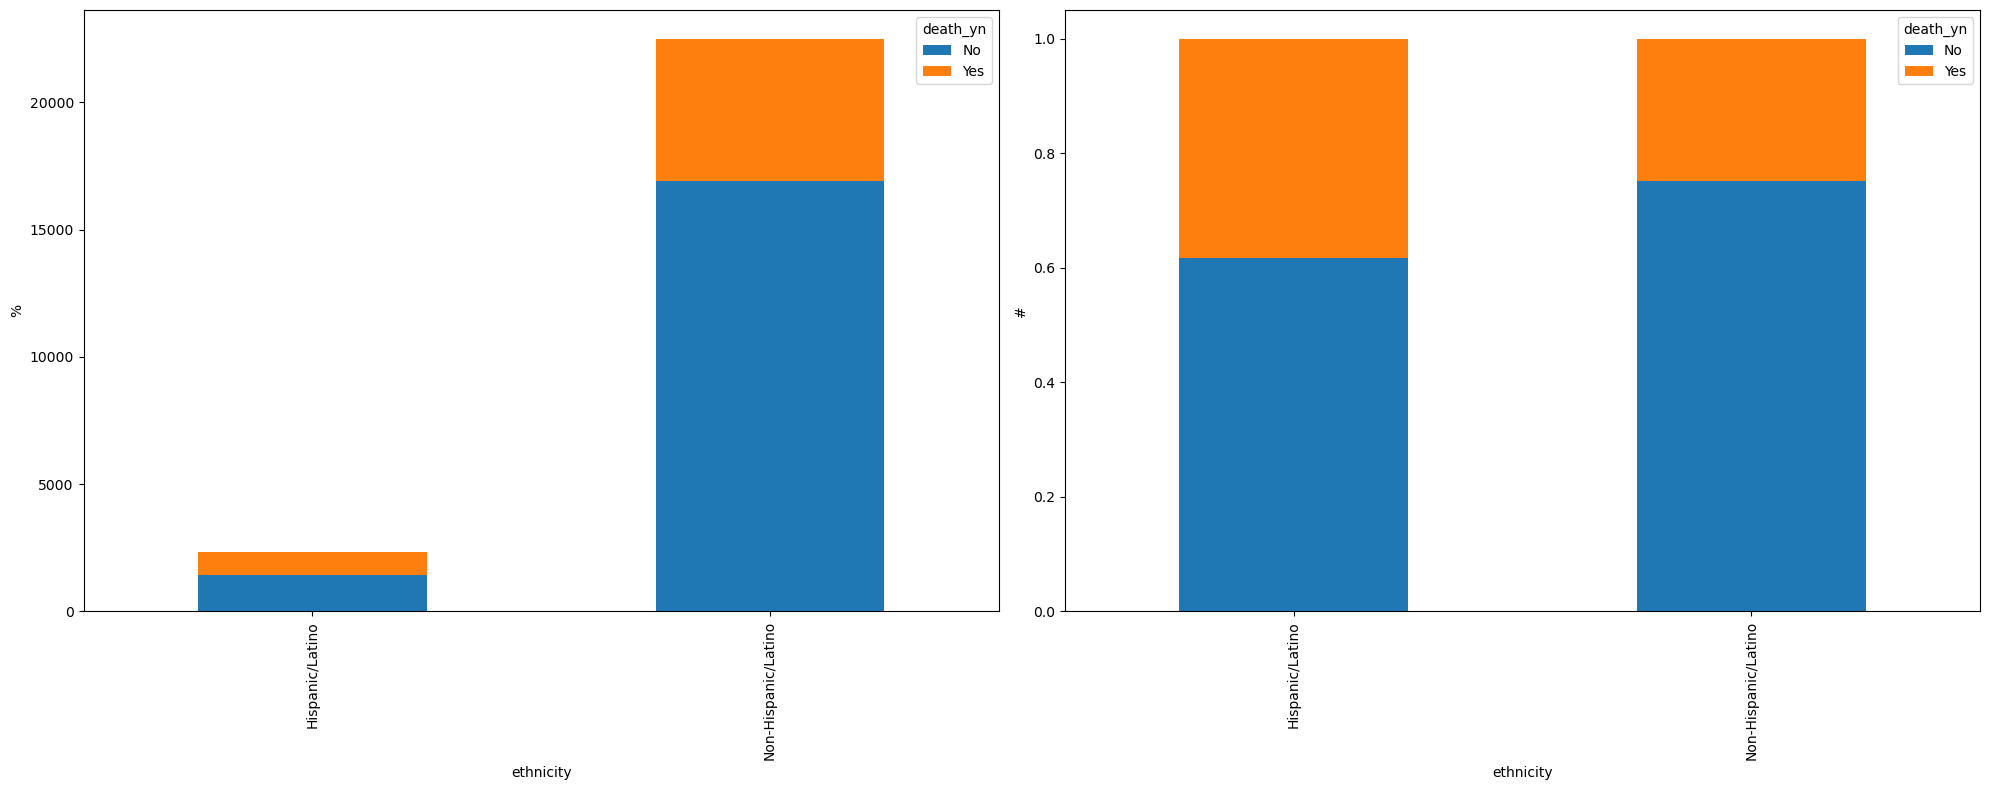

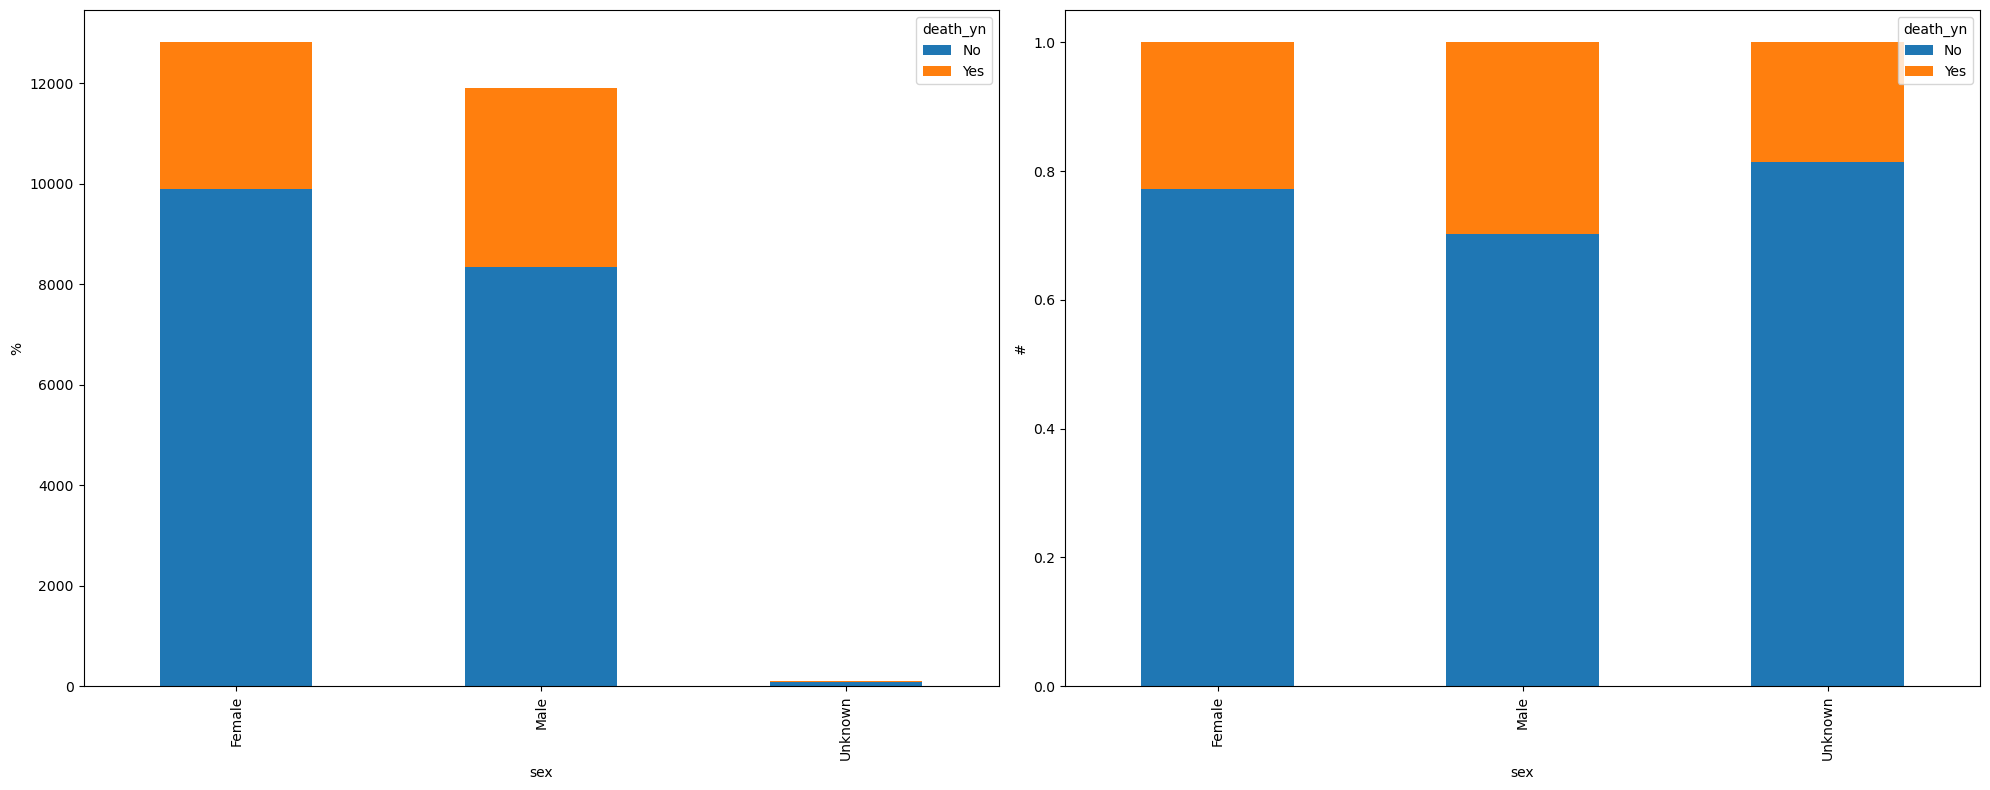

In [237]:

target_features = [train['race'], train['ethnicity'], train['sex']]
select_features = [train['death_yn']]

for target_feature in target_features:

    for feature in select_features:

        fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
        train.groupby([target_feature, feature]).size().unstack().plot(kind='bar', stacked=True, ax=axs[0])
        axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=10)
        axs[0].set_ylabel('%')

        train.groupby([target_feature, feature]).size().unstack().apply(lambda x: x/x.sum(), axis=1).plot(kind='bar', stacked=True, ax=axs[1])
        axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=10)
        axs[1].set_ylabel('#')
        
        plt.tight_layout()
        plt.show()

# Observations/Summary:

1. As the COVID19 pandemic progressed, we can generally observe both a reduction in the number of deaths per month and the proporption of deaths with regards the whole, month-on-month. The outlier here is January 2022. From the CDC dataset provided, we cannot discern whether or not the patient was vaccinated, however we can use the months here as a proxy for the Vaccine rollout program in the US, which began mid-December 2020 and had more or less concluded by the end of the following year. The death ratio falling against total cases broadly follows the vaccination rollout scheme, despite this information not formally recorded in our dataset.

2. The data also suggests that age is a predominant and robust factor when gauging the impact contracting COVID will have on your health. Our data shows that those who belong to the oldest age bracket (65+) and test positive for COVID are fare more likely to die than those who are younger (compare 65+ against 0-17 years old). Our data also shows that those who are older are more exposed to the risk of COVID, in that the oldest age bucket leads in terms of hospitalisations, ICU admissions, and underlying conditions in comparison to the other age brackets. This aligns with what is now known about COVID-19, that older adults and those with underlying health conditions are considered to be at a higher risk of severe illness and death from COVID-19. 

3. The data also demonstrates that having underlying medical conditions increases the risk of hospitalisation, ICU admission, and death from COVID-19. And while we do not get access to the comorbidities affecting the patients in our dataset, those who reported as having underlying conditions such as diabtes, hypertension, obesity (etc.), confer a much higher risk of death from COVID-19 than others.

4. The data also shows that in the event of being admitted to hospital or the ICU, the success of making a full recovery is limited, and drasticly decreases the older you are. The data also proves the opposite whereby the younger you are the more resilient you are to COVID, leading to far fewer hospitalisation, admissions to ICU, and deaths. 

5. The data also shows that minorities, categorised in our race and ethnicity features (Black, Hispanic, Asian), are hospitalised, admitted to ICU, and die more regularly than their white counterparts pro rata. Without more granular information on our patient it is hard to say exactly what factors are driving these disparities: access to healthcare; wealth; etc.,

6. The dataset also shows that there is a gender discrepancy in COVID-19 cases, with females accounting for a higher proportion of cases than males. However, this trend is reversed for hospitalisations, ICU admissions, and deaths, where males are more likely to be affected.

7. It is also difficult to surmise from our dataset the impact of locality has on a given patient's likelihood to survive. While the data shows that certain states have higher rates of hospitalisations, ICU admissions, and deaths given the absence of other qualifying datapoints (population density, hospitals in given county, bed-availabilty etc.,) it is quite difficult to gauge the impact a given county or state has on a patient, despite what you might first assume.

8. Our dataset also shows that those who knew that they had been exposed to COVID fared better in terms of hospitalisations, ICU admissions, and deaths than in comparison to those we were unsure. 

9. Our dataset also suggests that there are seasonal increases of COVID cases during the winter months, with the values rising to a head at about January and hitting its nadir during the summer until 2022.

10. The data also demonstrates that there is a week correlation between case_onset_intervals and case_positive_specimen_intervals, with the correlation coefficient is close to zero. This indicates that the timing of when a person experiences symptoms (case onset interval) and when they test positive for COVID-19 (case positive specimen interval) are not strongly associated with each other.


# Task 2: Linear Regression

The aim of this task is to perform some basic predictive analysis on the data prepared in task one. To this end, a linear regression model will be created using the training data yielded by the train-test split from the previous task. The features to be analyzed in this section are (INSERT FEATURES HERE). The model will then be evaluated based on its performance using the training data, the test data, and other linear regression models trained on the full dataset. 

# Task 4: Random Forest
### Train a random forest model to predict the target feature

Subset of features: ['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']

Target feature: ['death_yn']

In [238]:
random_forest_features = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'death_yn']]

for f in random_forest_features:
    print(f, random_forest_features[f].dtypes)

case_month object
age_group object
hosp_yn object
icu_yn object
underlying_conditions_yn object
death_yn object


In [239]:
random_forest_features_train = train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn', 'death_yn']]
random_forest_features_test = test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn','death_yn']]

for f in random_forest_features:
    print(f, random_forest_features[f].unique())

case_month ['2021-01' '2022-02' '2020-12' '2022-06' '2021-11' '2021-09' '2020-04'
 '2022-01' '2020-11' '2021-05' '2021-12' '2020-09' '2020-06' '2020-05'
 '2020-07' '2021-03' '2020-10' '2022-08' '2022-05' '2021-08' '2020-08'
 '2021-07' '2022-07' '2022-04' '2022-09' '2021-10' '2020-03' '2022-03'
 '2021-04' '2021-02' '2022-10' '2021-06' '2022-11' '2020-02' '2020-01']
age_group ['18 to 49 years' '65+ years' '50 to 64 years' '0 - 17 years']
hosp_yn ['No' 'Yes' 'Unknown']
icu_yn ['Missing' 'No' 'Yes']
underlying_conditions_yn ['Unknown' 'Yes' 'No']
death_yn ['No' 'Yes']


In [240]:
month_map = {'2020-01': 0, 
             '2020-02': 1, 
             '2020-03': 2, 
             '2020-04': 3,
             '2020-05': 4,
             '2020-06': 5,
             '2020-07': 6,
             '2020-08': 7,
             '2020-09': 8,
             '2020-10': 9,
             '2020-11': 10,
             '2020-12': 11,
             '2021-01': 12,
             '2021-02': 13,
             '2021-03': 14,
             '2021-04': 15,
             '2021-05': 16,
             '2021-06': 17,
             '2021-07': 18,
             '2021-08': 19,
             '2021-09': 20,
             '2021-10': 21,
             '2021-11': 22,
             '2021-12': 23,
             '2022-01': 24,
             '2022-02': 25,
             '2022-03': 26,
             '2022-04': 27,
             '2022-05': 28,
             '2022-06': 29,
             '2022-07': 30,
             '2022-08': 31,
             '2022-09': 32,
             '2022-10': 33,
             '2022-11': 34}

random_forest_features_train['case_month'] = random_forest_features_train['case_month'].map(month_map)
random_forest_features_test['case_month'] = random_forest_features_test['case_month'].map(month_map)


/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/1860983942.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_train['case_month'] = random_forest_features_train['case_month'].map(month_map)
/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/1860983942.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_test['case_month'] = random_forest_features_test['case_month'].map(month_map)


In [241]:
age_map = {'0 - 17 years': 0, 
           '18 to 49 years': 1, 
           '50 to 64 years': 2, 
           '65+ years': 3
           }

random_forest_features_train['age_group'] = random_forest_features_train['age_group'].map(age_map)
random_forest_features_test['age_group'] = random_forest_features_test['age_group'].map(age_map)

/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/3426214286.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_train['age_group'] = random_forest_features_train['age_group'].map(age_map)
/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/3426214286.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_test['age_group'] = random_forest_features_test['age_group'].map(age_map)


In [242]:
hosp_map = {'Yes': 0, 
            'No': 1, 
            'Unknown': 2, 
            }

random_forest_features_train['hosp_yn'] = random_forest_features_train['hosp_yn'].map(hosp_map)
random_forest_features_test['hosp_yn'] = random_forest_features_test['hosp_yn'].map(hosp_map)

/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/308570975.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_train['hosp_yn'] = random_forest_features_train['hosp_yn'].map(hosp_map)
/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/308570975.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_test['hosp_yn'] = random_forest_features_test['hosp_yn'].map(hosp_map)


In [243]:
icu_map = {'Yes': 0, 
            'No': 1, 
            'Missing': 2, 
            }

random_forest_features_train['icu_yn'] = random_forest_features_train['icu_yn'].map(icu_map)
random_forest_features_test['icu_yn'] = random_forest_features_test['icu_yn'].map(icu_map)

/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/2979060126.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_train['icu_yn'] = random_forest_features_train['icu_yn'].map(icu_map)
/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/2979060126.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_test['icu_yn'] = random_forest_features_test['icu_yn'].map(icu_map)


In [244]:
underlying_map = {'Yes': 0, 
            'No': 1, 
            'Unknown': 2, 
            }

random_forest_features_train['underlying_conditions_yn'] = random_forest_features_train['underlying_conditions_yn'].map(underlying_map)
random_forest_features_test['underlying_conditions_yn'] = random_forest_features_test['underlying_conditions_yn'].map(underlying_map)

/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/461644786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_train['underlying_conditions_yn'] = random_forest_features_train['underlying_conditions_yn'].map(underlying_map)
/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/461644786.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_test['underlying_conditions_yn'] = random_forest_features_test['underlying_conditions_yn'].map(underl

In [245]:
death_map = {'Yes': 0,
             'No': 1,
             }

random_forest_features_train['death_yn'] = random_forest_features_train['death_yn'].map(death_map)
random_forest_features_test['death_yn'] = random_forest_features_test['death_yn'].map(death_map)

/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/2137800757.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_train['death_yn'] = random_forest_features_train['death_yn'].map(death_map)
/var/folders/cc/fnysfvwx6klc6rp9hhrkfr3r0000gn/T/ipykernel_7211/2137800757.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_forest_features_test['death_yn'] = random_forest_features_test['death_yn'].map(death_map)


In [246]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

x_train = random_forest_features_train[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
y_train = random_forest_features_train['death_yn']

x_test = random_forest_features_test[['case_month', 'age_group', 'hosp_yn', 'icu_yn', 'underlying_conditions_yn']]
y_test = random_forest_features_test['death_yn']

rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.918609022556391


In [247]:
y_pred = rfc.predict(x_train)
print(y_pred[:10])
print(rfc.predict_proba(x_train)[:10])

[1 1 0 1 1 1 0 0 1 1]
[[0.00283577 0.99716423]
 [0.         1.        ]
 [0.9563313  0.0436687 ]
 [0.         1.        ]
 [0.         1.        ]
 [0.35897642 0.64102358]
 [0.85393569 0.14606431]
 [0.97495437 0.02504563]
 [0.         1.        ]
 [0.00264443 0.99735557]]


In [248]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

y_pred = rfc.predict(x_train)
print("Accuracy: ", accuracy_score(y_train, y_pred))


Accuracy:  0.9251963746223565


In [249]:
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred))

Confusion Matrix:
 [[ 5769   724]
 [ 1133 17199]]


	Predicted Positive	Predicted Negative
Actual Positive	True Positives (TP) = 5769	False Negatives (FN) = 724
Actual Negative	False Positives (FP) = 1133	True Negatives (TN) = 17199

In [250]:
print("Classification Report:\n", classification_report(y_train, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      6493
           1       0.96      0.94      0.95     18332

    accuracy                           0.93     24825
   macro avg       0.90      0.91      0.91     24825
weighted avg       0.93      0.93      0.93     24825



In [251]:
print("Precision:", precision_score(y_train, y_pred))


Precision: 0.9596049768453941


In [252]:
print("Recall:", recall_score(y_train, y_pred))


Recall: 0.9381955051276456


In [253]:
print("F1 Score:", f1_score(y_train, y_pred))

F1 Score: 0.9487794786925939
